#Data Presentation

In [364]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('ca-dealers-used.csv', index_col='id')
df.sort_index()

C:\Users\OLUWAS~1\AppData\Local\Temp/ipykernel_23384/2221995647.py:5: DtypeWarning: Columns (13,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('ca-dealers-used.csv', index_col='id')


,vin,price,miles,stock_no,year,make,model,trim,body_type,vehicle_type,drivetrain,transmission,fuel_type,engine_size,engine_block,seller_name,street,city,state,zip
id,,,,,,,,,,,,,,,,,,,,
00000ae8-68e1,KNDJP3A57G7836899,14995.0,75732.0,463,2016.0,Kia,Soul,Plus,Hatchback,Car,FWD,Automatic,Unleaded,2.0,I,gauvin auto lte,389 West Saint Peter Boulevard.,Caraquet,NB,E1W 1A3
00004b94-b5f3,1GKS2GKJ0LR146503,72888.0,5924.0,295016A,2020.0,GMC,Yukon XL,SLT,SUV,Truck,4WD,Automatic,Unleaded,6.2,V,gateway chevrolet,2 Gateway Dr,Brampton,ON,L6T 4A7
000069d2-abee,1FTEW1EG6FFB93664,39480.0,123004.0,SPC3936A,2015.0,Ford,F-150,Lariat,Pickup,Truck,4WD,Automatic,Unleaded,3.5,V,sherwood park chevrolet,500 Premier Way,Sherwood Park,AB,T8H 0R5
0000ad5a-aa21,2T3BFREV4HW658265,20750.0,93825.0,310295A,2017.0,Toyota,RAV4,LE,SUV,Truck,4WD,Automatic,Unleaded,2.5,I,weins canada,3120 Steeles Avenue East,Markham,ON,L3R 1G9
0000d246-c85a,KNDETCA22M7177970,31879.0,2710.0,L20706-2,2021.0,Kia,Seltos,SX,SUV,Truck,4WD,Automatic,Unleaded,1.6,I,land rover vancouver,1730 Burrard Street,Vancouver,BC,V6J 3G7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffff5a05-67e6,1FAHP2MK1FG118750,7000.0,211000.0,20N6361,2015.0,Ford,Taurus,NaN,Sedan,NaN,4WD,Automatic,NaN,NaN,NaN,redline auto sales,2040 Dundas St,London,ON,N5V 1R2
ffff6688-8810,5YJSA1H14EFP51474,42988.0,114827.0,P51474,2014.0,Tesla,Model S,S,Hatchback,Car,RWD,Automatic,Electric,NaN,NaN,auto house sunridge,3312 26 Street Northeast,Calgary,AB,T1Y 4T7
ffff7bcd-c582,JTHCE1D29E5003276,24995.0,123895.0,FSPORT,2014.0,Lexus,IS,350,Sedan,Car,4WD,Automatic,Premium Unleaded,3.5,V,montreal ouest motors inc.,55 Chemin De Lotbinire,Vaudreuil-dorion,QC,J7V 2T5


### Contextualization and Description of Variables

Our dataset is the collection of inventory of used cars from various auto dealers across Canada. The data depicts the market activity of used cars sold by different dealers in the various provinces of Canada. The following are the variables in the dataset and their description:

**id** :    Unique identifier for each row.<br>
            *Data type: string*<br>
**vin** :   17 character long vehicle identification number. This is the value that uniquely identify each vehicle.<br> 
            *Data type: string* <br>
**price** : Price of the vehicle. This is the value that we will try to predict.<br>
            *Data type: float* <br>
**miles** : Number of miles/odometer on the vehicle. The higher the number, the more the vehicle has been driven or used.<br>
            *Data type: float* <br>
**year** :  Model year of the vehicle - Decoded from VIN. This is the year the vehicle was manufactured. <br>
            *Data type: float* <br>
**make** :  Make of the vehicle - Decoded from VIN. This is the manufacturer of the vehicle. <br>
            *Data type: string* <br>
**model** : Model of the vehicle - Decoded from VIN. It is the specific model of the vehicle. <br>
            *Data type: string* <br>
**body_type** : Body type of the vehicle - Decoded from VIN. This is the type of vehicle. For example, sedan, coupe, SUV, etc. <br>
            *Data type: string* <br>
**vehicle_type** : This is the type of vehicle. For example, car, truck, etc. <br>
            *Data type: string* <br>
**engine_size** : This is the size of the engine in liters. <br>
            *Data type: float*<br>
**fuel_type** : This is the type of fuel the vehicle uses. For example, gasoline, diesel, etc. <br>
            *Data type: string* <br>
**transmission** : Transmission type of the vehicle. The transmission type is either automatic or manual. <br>
            *Data type: string* <br>
**drivetrain** : Drivetrain type of the vehicle. The drivetrain type is either 4WD, FWD, or RWD. <br>
            *Data type: string* <br>
**seller_name** : Name of the seller or dealership. <br>
            *Data type: string* <br>
**city** : City of the seller or dealership. <br>
            *Data type: string* <br>
**state** : State of the seller or dealership. <br>
            *Data type: string* <br>



In [301]:
df.describe()

,price,miles,year,engine_size
count,3.584860e+05,3.665900e+05,393586.000000,320950.000000
mean,2.601902e+04,7.566339e+04,2016.414829,2.785073
std,2.064007e+04,5.775442e+04,3.345400,1.236639
min,0.000000e+00,0.000000e+00,1981.000000,0.600000
25%,1.490000e+04,3.491375e+04,2015.000000,2.000000
50%,2.190000e+04,6.232800e+04,2017.000000,2.400000
75%,3.199500e+04,1.032830e+05,2019.000000,3.500000
max,1.288888e+06,2.300033e+06,2022.000000,8.400000


In [365]:
# generates and returns a random sample of indices [0...n-1] of length, size_sub_df
def random_sampler(size_initial_df,  size_sub_df):
    bin_size = round(size_initial_df/size_sub_df)
    sample_indices = []
    low = 0
    high = 1

    for i in range(0, size_sub_df+1):
        sample_indices.append(np.random.randint((low*bin_size), (high*bin_size)))
        low+=1
        high+=1

    return sample_indices

# generate a list of 1500 random indices between 0 and n-1; n=len(df)
sample_indices = random_sampler(len(df), 1500)
# display(sample_indices)

# use generated indices to sample initial dataframe and create and subset
df_sub = df.iloc[sample_indices, :]

order_of_cols = ['vin', 'make', 'model', 'year', 'miles', 'price', 'engine_size', 'body_type',  'vehicle_type', 'fuel_type', 'transmission', 'drivetrain', 'seller_name', 'city', 'state']
df_sub = df_sub[order_of_cols]
display(df_sub)


,vin,make,model,year,miles,price,engine_size,body_type,vehicle_type,fuel_type,transmission,drivetrain,seller_name,city,state
id,,,,,,,,,,,,,,,
a319694a-d8e2,1C6RD7KT9CS338184,RAM,Ram 1500 Pickup,2012.0,126500.0,21499.0,5.7,Pickup,Truck,E85 / Unleaded; Unleaded,Automatic,4WD,everyone drives,Fredericton,NB
0dc217f6-1a21,1FTFW1E54JKF24146,Ford,F-150,2018.0,54606.0,42299.0,5.0,Pickup,Truck,Unleaded / Unleaded,Automatic,4WD,lincoln,Peterborough,ON
19a0b91a-69f7,1FTFW1E5XJFE12539,Ford,F-150,2018.0,39672.0,44888.0,5.0,Pickup,Truck,Unleaded / Unleaded,Automatic,4WD,oak-land ford lincoln,Oakville,ON
c4a528c6-e0ca,1G1RA6S56HU215086,Chevrolet,Volt,2017.0,37161.0,20995.0,1.5,Hatchback,Car,Electric / Premium Unleaded,Automatic,FWD,elite mazda,Gatineau,QC
dcf11a91-5234,1G1RB6S52JU108846,Chevrolet,Volt,2018.0,80332.0,23998.0,1.5,Hatchback,Car,Electric / Premium Unleaded,Automatic,FWD,hgrgoire nissan saint-eustache,Saint-eustache,QC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8e3d8338-df5f,JTHU9JBH5K2001781,Lexus,UX,2019.0,23626.0,35886.0,2.0,SUV,Truck,Electric / Unleaded,Automatic,4WD,carhub north york chrysler jeep dodge ram fiat,Vaughan,ON
356bf3af-eca6,JTMDJREV9JD157754,Toyota,RAV4,2018.0,54943.0,33885.0,2.5,SUV,Truck,Electric / Unleaded,Automatic,4WD,montmagny toyota,Montmagny,QC
c0a8e1a3-e2ba,JTMRJREVXGD004329,Toyota,RAV4,2016.0,NaN,18049.0,2.5,SUV,Truck,Electric / Unleaded,Automatic,4WD,barrie chrysler dodge jeep ram,Barrie,ON


#Data Cleaning

In [366]:
#Drop Duplicate VINS so we don't have thesame vehicle more than once
df_sub.drop_duplicates(subset='vin', keep='first', inplace=True)

#Function to delete random data from a column
def drop_random_rows(data, attribute, fraction):
    for col in data.columns:
        if col == attribute:
            data.loc[data.sample(frac=fraction).index, col] = np.nan
            
drop_random_rows(df_sub, 'year', 0.2) #Remove 20% data from year
df_sub.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1501 entries, a319694a-d8e2 to a75647d4-d3c2
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   vin           1501 non-null   object 
 1   make          1501 non-null   object 
 2   model         1486 non-null   object 
 3   year          1201 non-null   float64
 4   miles         1396 non-null   float64
 5   price         1369 non-null   float64
 6   engine_size   1224 non-null   float64
 7   body_type     1377 non-null   object 
 8   vehicle_type  1360 non-null   object 
 9   fuel_type     1231 non-null   object 
 10  transmission  1357 non-null   object 
 11  drivetrain    1346 non-null   object 
 12  seller_name   1495 non-null   object 
 13  city          1474 non-null   object 
 14  state         1474 non-null   object 
dtypes: float64(4), object(11)
memory usage: 219.9+ KB


In [367]:
"""
We are able to fill missing year from Vehicle VIN.
This function generates year of the vehicle from the VIN.
"""

def generate_year(vin):
    decoder = {'1':'2001', '2': '2002', '3': '2003', '4':'2004', '5':'2005', '6':'2006', '7':'2007', '8':'2008', '9':'2009', 'A':'2010', 'B':'2011', 
               'C':'2012', 'D':'2013', 'E':'2014', 'F':'2015', 'G':'2016', 'H':'2017', 'J':'2018', 'K':'2019', 'L':'2020', 'M':'2021', 'N':'2022'}
    vin = str(vin)
    if (len(vin) != 17) :
        return
    else:
        year_code = str(vin)[-8]
        
        for key,value in decoder.items():
            if year_code == key:
                return value      
    
df_sub['year'] = df_sub['vin'].apply(generate_year)
df_sub.sort_values(by=['year'], ascending=False)
df_sub.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1501 entries, a319694a-d8e2 to a75647d4-d3c2
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   vin           1501 non-null   object 
 1   make          1501 non-null   object 
 2   model         1486 non-null   object 
 3   year          1501 non-null   object 
 4   miles         1396 non-null   float64
 5   price         1369 non-null   float64
 6   engine_size   1224 non-null   float64
 7   body_type     1377 non-null   object 
 8   vehicle_type  1360 non-null   object 
 9   fuel_type     1231 non-null   object 
 10  transmission  1357 non-null   object 
 11  drivetrain    1346 non-null   object 
 12  seller_name   1495 non-null   object 
 13  city          1474 non-null   object 
 14  state         1474 non-null   object 
dtypes: float64(3), object(12)
memory usage: 219.9+ KB


Ages Before
Oldest: 20
Newest: 1
<class 'pandas.core.frame.DataFrame'>
Index: 1501 entries, a319694a-d8e2 to a75647d4-d3c2
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   vin           1501 non-null   object 
 1   make          1501 non-null   object 
 2   model         1486 non-null   object 
 3   year          1501 non-null   int32  
 4   miles         1396 non-null   float64
 5   price         1369 non-null   float64
 6   engine_size   1224 non-null   float64
 7   body_type     1377 non-null   object 
 8   vehicle_type  1360 non-null   object 
 9   fuel_type     1231 non-null   object 
 10  transmission  1357 non-null   object 
 11  drivetrain    1346 non-null   object 
 12  seller_name   1495 non-null   object 
 13  city          1474 non-null   object 
 14  state         1474 non-null   object 
 15  age           1501 non-null   int64  
dtypes: float64(3), int32(1), int64(1), object(11)
memory usage: 225.8

None

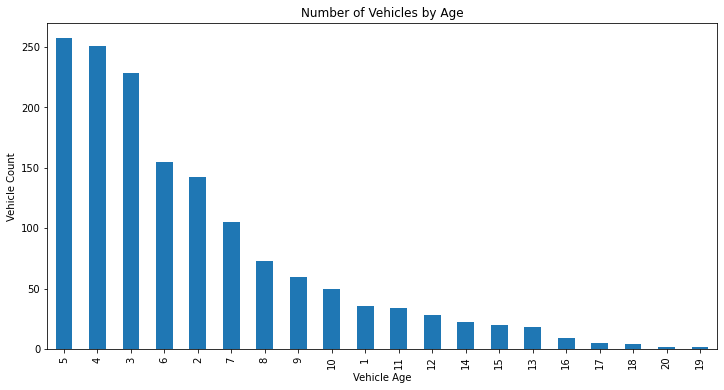

In [368]:
df_sub['year'] = df_sub['year'].astype('int') # convert year to integer because years cannot have decimal points

df_sub['age'] = df_sub.year.apply(lambda x: int(2022-x)) # creating age column to know the age of the vehicles in our dataset
print(f"Ages Before\nOldest: {df_sub.age.max()}\nNewest: {df_sub.age.min()}")
display(df_sub.info())

"""We will plot a line plot to see the number of vehicles by age in order to know if we should keep or drop
rows based on the age of the vehicle"""

#Plotting the numbers of vehicles by year
df_sub['age'].value_counts().plot(kind='bar', figsize = (12, 6), title = 'Number of Vehicles by Age')
plt.xlabel('Vehicle Age')
plt.ylabel('Vehicle Count')
plt.show()


Ages After
Oldest: 15
Newest: 1
<class 'pandas.core.frame.DataFrame'>
Index: 1479 entries, a319694a-d8e2 to a75647d4-d3c2
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   vin           1479 non-null   object 
 1   make          1479 non-null   object 
 2   model         1465 non-null   object 
 3   year          1479 non-null   int32  
 4   miles         1376 non-null   float64
 5   price         1352 non-null   float64
 6   engine_size   1209 non-null   float64
 7   body_type     1357 non-null   object 
 8   vehicle_type  1340 non-null   object 
 9   fuel_type     1216 non-null   object 
 10  transmission  1340 non-null   object 
 11  drivetrain    1329 non-null   object 
 12  seller_name   1473 non-null   object 
 13  city          1453 non-null   object 
 14  state         1453 non-null   object 
 15  age           1479 non-null   int64  
dtypes: float64(3), int32(1), int64(1), object(11)
memory usage: 190.7+

None

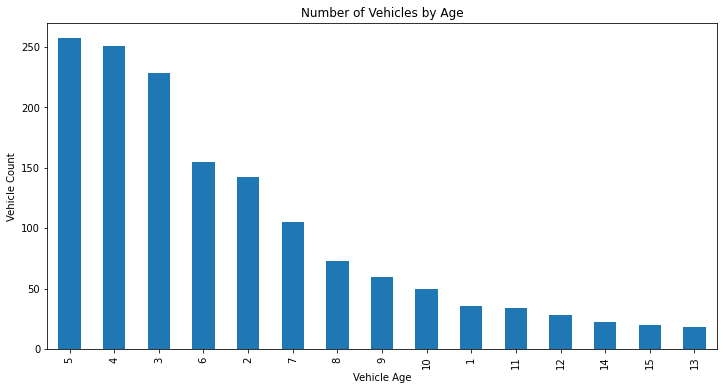

In [369]:
"""
From our plot, we can observe that the vehicles that are newer have higher numbers than older vehicles.
We will therefore drop rows with older cars. We will work with cars between ages 1 - 15
"""

df_sub = df_sub[(df_sub['age']>= 0) & (df_sub['age'] <= 15)] # removing vehicles that are older than 20 years old
print(f"Ages After\nOldest: {df_sub.age.max()}\nNewest: {df_sub.age.min()}")
display(df_sub.info())

#Plotting the numbers of vehicles by year after removi g older cars
df_sub['age'].value_counts().plot(kind='bar',figsize = (12, 6), title = 'Number of Vehicles by Age')
plt.xlabel('Vehicle Age')
plt.ylabel('Vehicle Count')
plt.show()

In [248]:
average_price = df_sub.groupby(['year', 'miles']).agg({'price':['mean']}).sort_values(by=['year', 'miles'], ascending=False)
average_price['price']

mean
year miles            
2021 45126.0   47348.0
     20195.0   30995.0
     19016.0   32989.0
     12542.0   27477.0
     11792.0   24990.0
...                ...
2007 132912.0      NaN
     126000.0   7995.0
     90000.0    5950.0
     62312.0   44888.0
     55727.0   23888.0

[1357 rows x 1 columns]

Q25: nan
Q75: nan


,vin,make,model,year,miles,price,engine_size,body_type,vehicle_type,fuel_type,transmission,drivetrain,seller_name,city,state,age
id,,,,,,,,,,,,,,,,


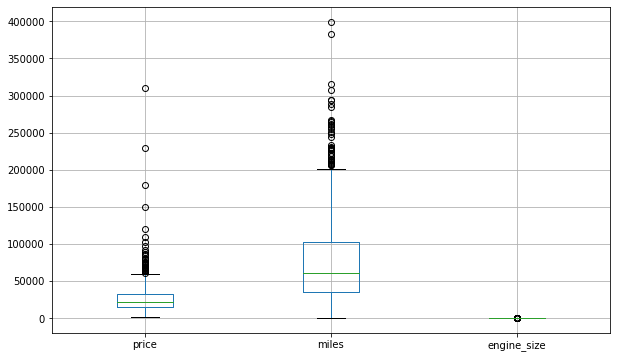

In [258]:
# #Plottng box plots to get outliers from price and miles

df_sub.boxplot(column=['price', 'miles', 'engine_size'], figsize=(10,6))

def remove_outliers(data, x):
        q25 = np.percentile(data[x], 25)
        q75 = np.percentile(data[x], 75)
        print(f"Q25: {q25}\nQ75: {q75}")
        iqr = q75 - q25
        lower_bound = q25 - (1.5 * iqr)
        upper_bound = q75 + (1.5 * iqr)
        return data[(data[x] > lower_bound) & (data[x] < upper_bound)]
         
df_sub_new = remove_outliers(df_sub, 'price')
display(df_sub_new)
    


In [250]:
df_sub.describe()

,miles,price,engine_size,age
count,1367.000000,1351.000000,1199.000000,1473.000000
mean,73288.249451,26329.962250,2.774395,5.315003
std,55018.252726,20852.827806,1.220000,2.809127
min,0.000000,2900.000000,1.000000,1.000000
25%,33813.500000,14995.000000,2.000000,3.000000
50%,61706.000000,22299.000000,2.400000,5.000000
75%,100358.000000,31986.000000,3.500000,7.000000
max,628708.000000,399999.000000,7.300000,15.000000
